# CME signatures

cme_sig.ipynb

https://github.com/cmoestl/cme_signatures

for paper Möstl et al. 2020 ApJ (in prep.)

Author: C. Moestl, IWF Graz, Austria; twitter @chrisoutofspace; https://github.com/cmoestl

**work in progress, last update July 2020**

For installation of a conda environment to run this code and how to download the data into a directory specified in config.py, see instructions in README.md of the heliocats github repo. Conda dependencies are listed under environment.yml, and pip in requirements.txt. Plots are saved in plots/ as png and pdf. 

**Data sources**


In situ data need to be downloaded into a directory defined in config.py from this figshare repository:
https://doi.org/10.6084/m9.figshare.11973693.v7
(which can also be cited by DOI).

---

**MIT LICENSE**

Copyright 2020, Christian Moestl

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.





In [20]:
from scipy import stats
import scipy.io
from matplotlib import cm
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
import astropy.constants as const
from sunpy.time import parse_time
import sunpy.time
import time
import pickle
import seaborn as sns
import os
import urllib
import json
import warnings
import importlib
import heliopy.spice as spice
import heliopy.data.spice as spicedata
import astropy

#!pip install 3DCORE if not already in the environment
import py3dcore
import heliosat
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc


#where the 6 in situ data files are located is read from input.py
#as data_path=....
from config import data_path
#reload again while debugging

#Convert this notebook to a script with jupyter nbconvert --to script cme_rate.ipynb
os.system('jupyter nbconvert --to script cme_rate.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

########### make directories first time
resdir='plots'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

plt.rcParams["figure.figsize"] = (15,8)

## 1 Settings and load data

In [2]:
plt.close('all')

print('cme_rate main program.')
print('Christian Moestl et al., IWF Graz, Austria')

#constants: 
#solar radius
Rs_in_AU=float(const.R_sun/const.au)
#define AU in km
AU_in_km=const.au.value/1e3

#set for loading
load_data=0


if load_data > 0:
    
    print('load data (takes a minute or so)')
    print('')

    
    ################## Spacecraft
    filemav='maven_2014_2018_removed_smoothed.p'
    [mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )

    print('load and merge Wind data HEEQ') 
    #from HELCATS HEEQ until 2018 1 1 + new self-processed data with heliosat and hd.save_wind_data
    filewin="wind_2007_2018_heeq_helcats.p" 
    [win1,hwin1]=pickle.load(open(data_path+filewin, "rb" ) )  
    
    #or use: filewin2="wind_2018_now_heeq.p" 
    filewin2="wind_2018_2019_heeq.p" 
    [win2,hwin2]=pickle.load(open(data_path+filewin2, "rb" ) )  

    #merge Wind old and new data 
    #cut off HELCATS data at end of 2017, win2 begins exactly after this
    win1=win1[np.where(win1.time < parse_time('2018-Jan-01 00:00').datetime)[0]]
    #make array
    win=np.zeros(np.size(win1.time)+np.size(win2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    win = win.view(np.recarray)  
    win.time=np.hstack((win1.time,win2.time))
    win.bx=np.hstack((win1.bx,win2.bx))
    win.by=np.hstack((win1.by,win2.by))
    win.bz=np.hstack((win1.bz,win2.bz))
    win.bt=np.hstack((win1.bt,win2.bt))
    win.vt=np.hstack((win1.vt,win2.vt))
    win.np=np.hstack((win1.np,win2.np))
    win.tp=np.hstack((win1.tp,win2.tp))
    win.x=np.hstack((win1.x,win2.x))
    win.y=np.hstack((win1.y,win2.y))
    win.z=np.hstack((win1.z,win2.z))
    win.r=np.hstack((win1.r,win2.r))
    win.lon=np.hstack((win1.lon,win2.lon))
    win.lat=np.hstack((win1.lat,win2.lat))

    print('Wind merging done')
    

    filevex='vex_2007_2014_sceq_removed.p'
    [vex,hvex]=pickle.load(open(data_path+filevex, 'rb' ) )
    
    filevex='vex_2007_2014_sceq.p'
    [vexnon,hvexnon]=pickle.load(open(data_path+filevex, 'rb' ) )
    

    filemes='messenger_2007_2015_sceq_removed.p'
    [mes,hmes]=pickle.load(open(data_path+filemes, 'rb' ) )

    filemes='messenger_2007_2015_sceq.p'
    [mesnon,hmesnon]=pickle.load(open(data_path+filemes, 'rb' ) )

 
    filestb='stereob_2007_2014_sceq.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
             
    filesta='stereoa_2007_2019_sceq.p'
    [sta,hsta]=pickle.load(open(data_path+filesta, "rb" ) )  

    filepsp='psp_2018_2019_sceq.p'
    [psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) )  
    
    fileuly='ulysses_1990_2009_rtn.p'
    [uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) ) 
    
    fileomni='omni_1963_2020.p'
    [omni,homni]=pickle.load(open(data_path+fileomni, "rb" ) ) 

    print('load all data done')

    
# ############# get positions from a 
# # pre-made IDL sav file for older spacecraft positions
# print()
# print('get positions')
# pos = hs.getcat('data/positions_2007_2023_HEEQ_6hours.sav')
# pos_time= hs.decode_array(pos.time) 
# pos_time_num=parse_time(pos_time).plot_date 
# print('positions done')

url='https://helioforecast.space/static/sync/icmecat/HELCATS_ICMECAT_v20.csv'
ic=pd.read_csv(url)
ic=ic.drop(columns='Unnamed: 0') #drop an extra index column
print('Keys (parameters) in this pandas data frame are:')
print(ic.keys())
print()

################### get indices of events for each spacecraft

mercury_orbit_insertion_time= parse_time('2011-03-18').datetime

#spacecraft near the 4 terrestrial planets
#get indices for Mercury after orbit insertion in March 2011
merci=np.where(np.logical_and(ic.sc_insitu =='MESSENGER', parse_time(ic.icme_start_time).datetime > mercury_orbit_insertion_time))[0]
vexi=np.where(ic.sc_insitu == 'VEX')[:][0]  
wini=np.where(ic.sc_insitu == 'Wind')[:][0] 
mavi=np.where(ic.sc_insitu == 'MAVEN')[:][0]    

#other spacecraft
#all MESSENGER events including cruise phase
mesi=np.where(ic.sc_insitu == 'MESSENGER')[:][0]   
pspi=np.where(ic.sc_insitu == 'ParkerSolarProbe')[:][0]    
stai=np.where(ic.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(ic.sc_insitu == 'STEREO-B')[:][0]    
ulyi=np.where(ic.sc_insitu == 'ULYSSES')[:][0]   


cme_rate main program.
Christian Moestl et al., IWF Graz, Austria
Keys (parameters) in this pandas data frame are:
Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std'],
      dtype='object')



In [3]:
ic

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_PSP_MOESTL_20181030_01,PSP,2018-10-30T20:25Z,2018-10-30T20:25Z,2018-10-31T08:19Z,0.2645,24.92,0.12,11.90,84.1,...,176.7,30.9,57176.8,17212.1,NaN,NaN,NaN,NaN,NaN,NaN
1,ICME_PSP_MOESTL_20181111_01,PSP,2018-11-11T23:51Z,2018-11-11T23:51Z,2018-11-12T05:59Z,0.2545,178.55,-1.12,6.13,98.9,...,168.5,51.3,73074.1,38992.7,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_PSP_MOESTL_20190315_01,PSP,2019-03-15T09:00Z,2019-03-15T12:11Z,2019-03-15T17:49Z,0.5465,-161.32,3.17,8.82,33.4,...,30.2,9.0,23399.7,16991.4,397.1,24.4,49.1,10.7,13.1,3.7
3,ICME_PSP_MOESTL_20190324_01,PSP,2019-03-24T03:45Z,2019-03-24T03:45Z,2019-03-24T17:38Z,0.3858,-148.82,2.03,13.88,34.0,...,52.4,10.1,40375.0,17986.7,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_PSP_MOESTL_20190725_01,PSP,2019-07-25T08:13Z,2019-07-25T08:13Z,2019-07-25T23:06Z,0.7739,49.91,3.89,14.88,13.7,...,19.9,6.8,77095.2,40614.1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,ICME_MAVEN_MOESTL_20160721_01,MAVEN,2016-07-21T15:48Z,2016-07-21T15:48Z,2016-07-23T07:34Z,1.4460,-24.03,1.04,39.77,7.3,...,1.0,0.4,558630.0,457819.5,NaN,NaN,NaN,NaN,NaN,NaN
735,ICME_MAVEN_MOESTL_20160907_01,MAVEN,2016-09-07T18:01Z,2016-09-08T12:31Z,2016-09-09T11:41Z,1.3997,-42.00,3.62,41.67,7.5,...,5.1,3.4,136514.3,33306.2,419.2,22.1,4.4,1.6,1.4,0.6
736,ICME_MAVEN_MOESTL_20170119_01,MAVEN,2017-01-19T05:53Z,2017-01-19T05:53Z,2017-01-20T23:08Z,1.4258,-91.69,4.75,41.25,5.5,...,2.6,0.8,223914.2,217699.9,NaN,NaN,NaN,NaN,NaN,NaN
737,ICME_MAVEN_MOESTL_20170303_01,MAVEN,2017-03-03T17:46Z,2017-03-03T17:46Z,2017-03-05T10:57Z,1.4763,-110.84,3.01,41.18,14.9,...,3.2,1.1,713452.5,322450.8,NaN,NaN,NaN,NaN,NaN,NaN


## 2 3DCORE modeling

### **Figure 1** ***


In [4]:
sns.set_context("talk")     
#sns.set_style('whitegrid',{'grid.linestyle': '--'})

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(12,9),dpi=80)


<Figure size 960x720 with 0 Axes>

Here 3DCORE is used to model synthetic observations of expanding flux ropes close to the Sun

In [21]:

#rc('text', usetex=True)
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

############### Model Settings
t_launch = datetime.datetime(2022, 6, 1, 20)

iparams_arr = np.array([[
    0,      # time offset
    145,    # l_1 (logitude)
    2.5,    # l_2 (latitude)
    0,      # o (inclination, orientation)
    0.24,   # d_1au (frontal width at 1AU)
    1,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    400,    # v_0 (initial velocty in)
    -5,      # tau (magnetic field twist)
    1,      # b_s (magnetic field scaling parameter)
    12,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


TP_A =  t_launch + datetime.timedelta(hours=4)
TP_B =  t_launch + datetime.timedelta(hours=26)

C_A = "xkcd:red"
C_B = "xkcd:blue"

C0 = "xkcd:black"
C1 = "xkcd:magenta"
C2 = "xkcd:orange"
C3 = "xkcd:azure"



class PSP_FIXED(heliosat.PSP):
    def __init__(self, t_fixed, **kwargs):
        self.t_fixed = t_fixed

        super(PSP_FIXED, self).__init__(**kwargs)

    def trajectory(self, t, frame, **kwargs):
        return super().trajectory(t=[self.t_fixed] * len(t), frame=frame, **kwargs)

setattr(heliosat, "PSP_FIXED", PSP_FIXED)

In [6]:
def measure(obj, sat, t0, t1, frame="HEEQ", bframe="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    o_s = inst.trajectory(t_s, frame=frame)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b

def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    ax.set_zlim([-view_radius, view_radius])
    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .05)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)

    ax.scatter(0, 0, 0, color="y", s=500)

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs)

def plot_3dcore_field(ax, obj, steps=500, step_size=0.005, **kwargs):
    q0 = kwargs.get("q0", np.array([1, .1, np.pi/2], dtype=np.float32)).astype(np.float32)

    fl = obj.visualize_fieldline(q0, steps=steps, step_size=step_size)

    ax.plot(*fl.T, **kwargs)

def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=4, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 25)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)



## **Figure 2**


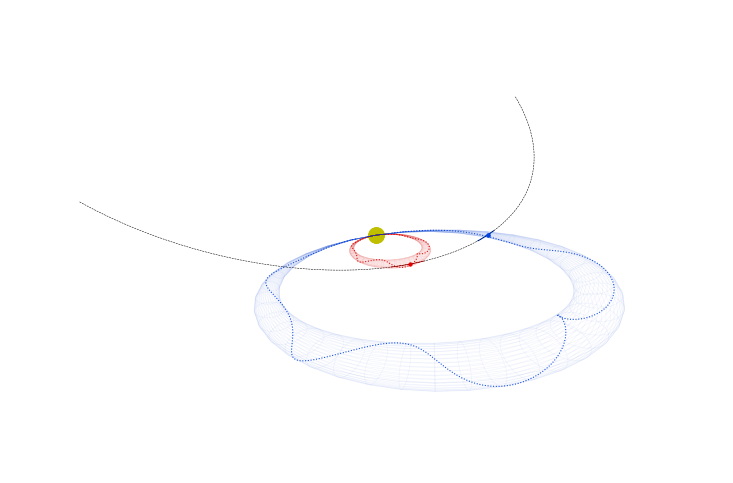

In [14]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 10),dpi=50)

ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=125, view_elev=40, view_radius=.15)
#plot_configure(ax, view_azim=125, view_elev=35, view_radius=.04)



plot_3dcore(ax, model_obj, TP_A, color=C_A)
plot_3dcore_field(ax, model_obj, color=C_A, steps=400, step_size=0.0005, lw=1.5, ls=":")
plot_traj(ax, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

plot_3dcore(ax, model_obj, TP_B, color=C_B)
plot_3dcore_field(ax, model_obj, color=C_B, steps=900, step_size=0.001, lw=1.5, ls=":")
plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)

plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

plt.tight_layout()

plt.savefig('plots/3dcore_1.pdf', dpi=300)
plt.savefig('plots/3dcore_1.png', dpi=300)


In [15]:
t1, btot1, bxyz1 = measure(model_obj, "PSP", TP_A - datetime.timedelta(hours=6), TP_A  + datetime.timedelta(hours=6), frame="ECLIPJ2000", bframe="SPP_RTN")
t2, btot2, bxyz2 = measure(model_obj, "PSP", TP_B - datetime.timedelta(hours=12), TP_B  + datetime.timedelta(hours=12), frame="ECLIPJ2000", bframe="SPP_RTN")

tf, btotf, bxyzf = measure(model_obj, "PSP_FIXED", TP_A - datetime.timedelta(hours=6), TP_A  + datetime.timedelta(hours=6), frame="ECLIPJ2000", bframe="SPP_RTN", satparams=TP_A)

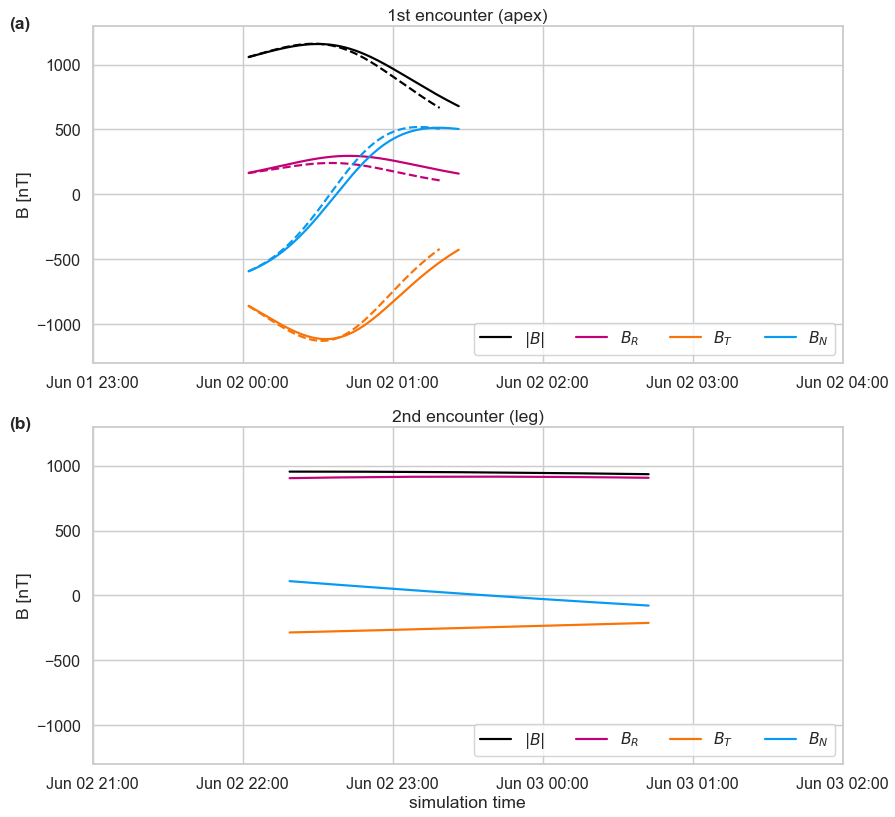

In [16]:
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(13, 12),dpi=70)

ax1 = fig.add_subplot(211)
ax1.set_title("1st encounter (apex)")

ax1.plot(t1, btot1, color=C0, label="$|B|$")
ax1.plot(t1, bxyz1[:, 0], color=C1, label="$B_R$")
ax1.plot(t1, bxyz1[:, 1], color=C2, label="$B_T$")
ax1.plot(t1, bxyz1[:, 2], color=C3, label="$B_N$")

ax1.plot(tf, btotf, color=C0, linestyle='--')
ax1.plot(tf, bxyzf[:, 0], color=C1, linestyle='--')
ax1.plot(tf, bxyzf[:, 1], color=C2, linestyle='--')
ax1.plot(tf, bxyzf[:, 2], color=C3, linestyle='--')

ax1.legend(loc="lower right", fontsize=16,ncol=4)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
ax1.set_ylabel('B [nT]')
plt.ylim(-1300,1300)
plt.xlim(datetime.datetime(2022,6,1,23,0),datetime.datetime(2022,6,2,4,0))



ax2 = fig.add_subplot(212)
ax2.set_title("2nd encounter (leg)")

ax2.plot(t2, btot2, color=C0, label="$|B|$")
ax2.plot(t2, bxyz2[:, 0], color=C1, label="$B_R$")
ax2.plot(t2, bxyz2[:, 1], color=C2, label="$B_T$")
ax2.plot(t2, bxyz2[:, 2], color=C3, label="$B_N$")

ax2.legend(loc="lower right", fontsize=16,ncol=4)
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
ax2.set_xlabel('simulation time')
ax2.set_ylabel('B [nT]')
plt.ylim(-1300,1300)
plt.xlim(datetime.datetime(2022,6,2,21,0),datetime.datetime(2022,6,3,2,0))


plt.tight_layout()


plt.annotate('(a)',[0.01,0.965],xycoords='figure fraction',weight='bold')
plt.annotate('(b)',[0.01,0.475],xycoords='figure fraction',weight='bold')

plt.savefig('plots/3dcore_components_1.pdf', dpi=300)
plt.savefig('plots/3dcore_components_1.png', dpi=300)

In [17]:
def plot_reconstruction(ax, obj, qs, **kwargs):

    ss = []

    for i in range(len(qs)):
        q = np.array([qs[i]])
        s = np.empty_like(q)

        obj.transform_qs(s, q)

        ss.append(s[0])

    ss = np.array(ss)

    ax.plot(*ss.T, **kwargs)

def reconstruct_path(obj, sat, t0, t1, frame="HEEQ", satparams=None):
    if satparams:
        inst = getattr(heliosat, sat)(satparams)
    else:
        inst = getattr(heliosat, sat)()

    t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]
    o_s = inst.trajectory(t_s, frame=frame)

    qs = []

    for i in range(len(t_s)):
        s = np.array([o_s[i]])
        q = np.empty_like(s)

        obj.propagate(t_s[i])
        obj.transform_sq(s, q)

        if q[0][0] < 1.0:
            qs.append(np.copy(q[0]))

    return qs

In [18]:
QPATH_PSP = reconstruct_path(model_obj, "PSP", TP_A - datetime.timedelta(hours=3), TP_A  + datetime.timedelta(hours=3), frame="ECLIPJ2000")
QPATH_PSP_FIXED = reconstruct_path(model_obj, "PSP_FIXED", TP_A - datetime.timedelta(hours=3), TP_A  + datetime.timedelta(hours=3), frame="ECLIPJ2000", satparams=TP_A)

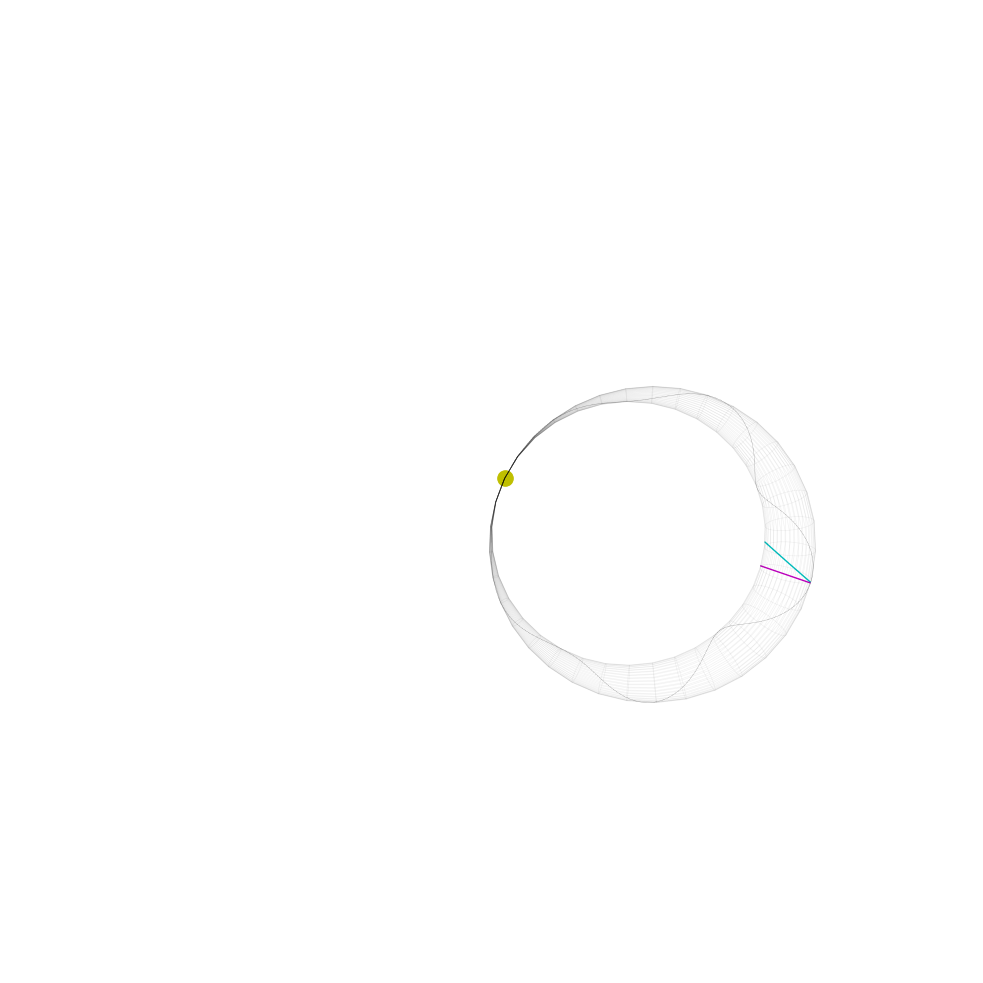

In [19]:
fig = plt.figure(figsize=(20, 20),dpi=50)
ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=80, view_elev=75, view_radius=.05)

plot_3dcore(ax, model_obj, TP_A, color=C0)
plot_3dcore_field(ax, model_obj, color=C0, steps=400, step_size=0.0005, lw=.5, ls=":")

plot_reconstruction(ax, model_obj, QPATH_PSP, color="c", ls="-", lw=2)
plot_reconstruction(ax, model_obj, QPATH_PSP_FIXED, color="m", ls="-", lw=2)

plt.tight_layout()

### make animation

***

# 3 Play with model settings

In [ ]:
############### Model Settings
t_launch = datetime.datetime(2022, 6, 1, 20)

iparams_arr = np.array([[
    0,      # time offset
    145,    # l_1 (longitude)
    2.5,    # l_2 (latitude)
    5,      # o (inclination, orientation)
    0.24,   # d_1au (frontal width at 1AU)
    1,   # delta (cross-section aspect ratio)
    5,      # r_0 (initialization distance in solar radii)
    250,    # v_0 (initial velocty in)
    -5,      # tau (magnetic field twist)
    1,      # b_s (magnetic field scaling parameter)
    12,     # b_1au (magnetic field strength at 1au)
    1.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


TP_A =  t_launch + datetime.timedelta(hours=5)
TP_B =  t_launch + datetime.timedelta(hours=24)

t1, btot1, bxyz1 = measure(model_obj, "PSP", TP_A - datetime.timedelta(hours=6), TP_A  + datetime.timedelta(hours=6), frame="ECLIPJ2000", bframe="SPP_RTN")
t2, btot2, bxyz2 = measure(model_obj, "PSP", TP_B - datetime.timedelta(hours=12), TP_B  + datetime.timedelta(hours=12), frame="ECLIPJ2000", bframe="SPP_RTN")
tf, btotf, bxyzf = measure(model_obj, "PSP_FIXED", TP_A - datetime.timedelta(hours=6), TP_A  + datetime.timedelta(hours=6), frame="ECLIPJ2000", bframe="SPP_RTN", satparams=TP_A)

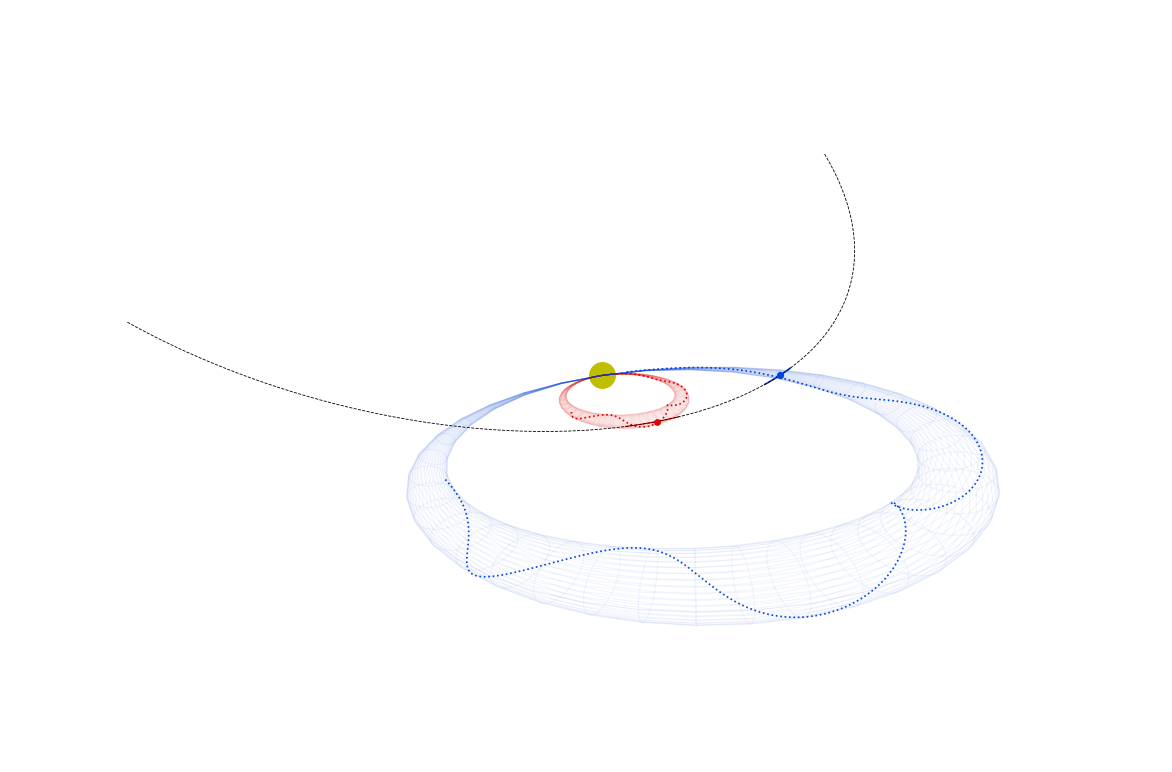

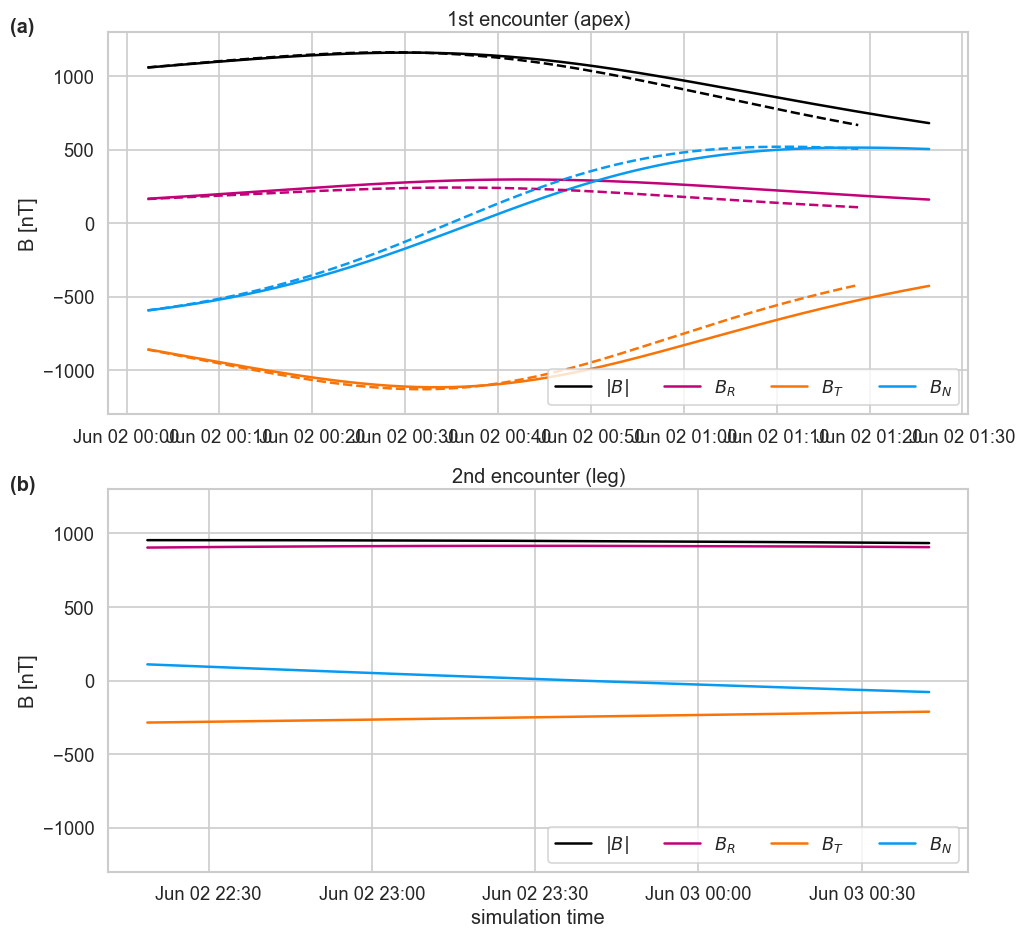

In [11]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15, 10),dpi=80)

ax = fig.add_subplot(111, projection='3d')

plot_configure(ax, view_azim=125, view_elev=40, view_radius=.15)
#plot_configure(ax, view_azim=125, view_elev=35, view_radius=.04)

plot_3dcore(ax, model_obj, TP_A, color=C_A)
plot_3dcore_field(ax, model_obj, color=C_A, steps=300, step_size=0.0005, lw=1.5, ls=":")
plot_traj(ax, "PSP", TP_A, frame="ECLIPJ2000", color=C_A)

plot_3dcore(ax, model_obj, TP_B, color=C_B)
plot_3dcore_field(ax, model_obj, color=C_B, steps=1500, step_size=0.0005, lw=1.5, ls=":")
plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color=C_B,lw=1.5)

plot_traj(ax, "PSP", TP_B, frame="ECLIPJ2000", color="k", traj_pos=False, traj_major=None, traj_minor=144,lw=1.5)

plt.tight_layout()


#########################################

sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(13, 12),dpi=80)

ax1 = fig.add_subplot(211)
ax1.set_title("1st encounter (apex)")

ax1.plot(t1, btot1, color=C0, label="$|B|$")
ax1.plot(t1, bxyz1[:, 0], color=C1, label="$B_R$")
ax1.plot(t1, bxyz1[:, 1], color=C2, label="$B_T$")
ax1.plot(t1, bxyz1[:, 2], color=C3, label="$B_N$")

ax1.plot(tf, btotf, color=C0, linestyle='--')
ax1.plot(tf, bxyzf[:, 0], color=C1, linestyle='--')
ax1.plot(tf, bxyzf[:, 1], color=C2, linestyle='--')
ax1.plot(tf, bxyzf[:, 2], color=C3, linestyle='--')

ax1.legend(loc="lower right", fontsize=16,ncol=4)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
ax1.set_ylabel('B [nT]')
plt.ylim(-1300,1300)
#plt.xlim(datetime.datetime(2022,6,1,22,0),datetime.datetime(2022,6,2,10,0))



ax2 = fig.add_subplot(212)
ax2.set_title("2nd encounter (leg)")

ax2.plot(t2, btot2, color=C0, label="$|B|$")
ax2.plot(t2, bxyz2[:, 0], color=C1, label="$B_R$")
ax2.plot(t2, bxyz2[:, 1], color=C2, label="$B_T$")
ax2.plot(t2, bxyz2[:, 2], color=C3, label="$B_N$")

ax2.legend(loc="lower right", fontsize=16,ncol=4)
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H:%M'))
ax2.set_xlabel('simulation time')
ax2.set_ylabel('B [nT]')
plt.ylim(-1300,1300)
#plt.xlim(datetime.datetime(2022,6,2,17,0),datetime.datetime(2022,6,3,5,0))


plt.tight_layout()


plt.annotate('(a)',[0.01,0.965],xycoords='figure fraction',weight='bold')
plt.annotate('(b)',[0.01,0.475],xycoords='figure fraction',weight='bold')

plt.savefig('plots/3dcore_components.png', dpi=300)
# plt.savefig('results/plots_rate/fig6_3dcore_components.png', dpi=300)